# Assignment 2 #

## step 1##
In first part of this task we have added the libraries that we are going to use .

In [1]:
import torch
from torch.autograd import Variable
import torch.utils.data as Data
import torch.optim  as optim
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import imageio

In [3]:
torch.manual_seed(1)

## Step 2 ##
Reading the Data in the CSV file
I have used "Metro Interstate Traffic Volume Data Set" from UCI (https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

In [4]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv',sep=',')

## step 3 ##
Map functions to transform input Columns.
In map_hoiday function I have classified non-holiday days as a 0 . 
In map_time function since traffic depends on the time of the day I have mapped date and time to hour of the day. 
and converted that string to Int.

In [5]:
def map_holiday(x):
    if x=="None":
        return 0
    else:
        return 1
def map_time(x):
    y = x.split(' ')
    hour = y[1].split(":")[0]
    return int(hour)

In [6]:
df['holiday'] = df['holiday'].map(map_holiday)
df['hour']= df['date_time'].map(map_time)

In [7]:
y= df[['traffic_volume']]
df=df.drop(['weather_description', 'date_time','weather_main','traffic_volume'], axis=1)
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,hour
0,0,288.28,0.0,0.0,40,9
1,0,289.36,0.0,0.0,75,10
2,0,289.58,0.0,0.0,90,11
3,0,290.13,0.0,0.0,90,12
4,0,291.14,0.0,0.0,75,13


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   holiday     48204 non-null  float64
 1   temp        48204 non-null  float64
 2   rain_1h     48204 non-null  float64
 3   snow_1h     48204 non-null  float64
 4   clouds_all  48204 non-null  float64
 5   hour        48204 non-null  float64
dtypes: float64(6)
memory usage: 2.2 MB


## step 4 ##
Helper function to convert numpy array and data frame to tensor. 

In [10]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

# convert a df to tensor to be used in pytorch
def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

def numpy_array_to_tensor(array):
    device = get_device()
    return torch.from_numpy(array).float().to(device)

## step 5 ##
Converting all input and output to min max scale inorder to avoid problem with gradient descent. Also have converted input
data into training data and testing data.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[["holiday", "temp","rain_1h","snow_1h","clouds_all","hour"]] = scaler.fit_transform(df[["holiday", "temp","rain_1h","snow_1h","clouds_all","hour"]])
y= scaler.fit_transform(y)

x_train,x_test,y_train,y_test = train_test_split(df,y, test_size=0.3, random_state=108, shuffle=True)

x_train = df_to_tensor(x_train)
x_test = df_to_tensor(x_test)
y_train = numpy_array_to_tensor(y_train)
y_test = numpy_array_to_tensor(y_test)

                

In [12]:
print(x_train.shape)

torch.Size([33742, 6])


## step 6 ##
converting input data into Dataset class so that it becomes easier to iterate through data. 

In [18]:
from torch.utils.data import Dataset, DataLoader
class MetroTrafficDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,index):
        return self.x[index],self.y[index]
        

In [20]:
train_dataset = MetroTrafficDataset(x_train,y_train)
train_loader = DataLoader(dataset=train_dataset,shuffle=True)

In [21]:
test_dataset = MetroTrafficDataset(x_test,y_test)
test_loader = DataLoader(dataset=test_dataset,shuffle=True)

## step 7 ##
In this part we have created feed forward neural with one hiddern layer. We have increased number of hidden layers from 12 to 22 . We will analyse the effect of increasing number of weights ( hidden nodes) on the test accuracy and computation time

In [ ]:
from torch import nn
from torchvision import transforms
import math
import time

input_size = 6
output_size = 1
number_of_hidden_weights = []
mse = []
execution_time = []

for i in range(12,23):
    start_time = time.time()
    hidden_size = i
    number_of_hidden_weights.append(i)
    model = nn.Sequential(nn.Linear(input_size,hidden_size),
                          nn.Sigmoid(),
                          nn.Linear(hidden_size,output_size))
    learning_rate = 1e-4
    criterion = nn.MSELoss() 
    optimizer = optim.SGD(model.parameters(),learning_rate)
    epochs = 50
    training_loss = []
    testing_loss = []
    
    for e in range(epochs):
        running_loss = 0
        validation_loss = 0
        for (x,y) in train_dataset:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output,y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        training_loss.append(running_loss/len(train_dataset))        
        for (x,y) in test_dataset:
            output = model(x)
            loss = criterion(output,y)
            validation_loss += loss.item()
        testing_loss.append(validation_loss/len(test_dataset))
        
    final_validation_loss = 0
    for  (x,y) in test_dataset:
        output = model(x)
        loss = criterion(output,y)
        final_validation_loss += loss.item()
    mse.append(final_validation_loss/len(test_dataset))
    execution_time.append(time.time() - start_time)   
    print(" number of nodes "+str(i)+" completed")

In [57]:
## used google cloud to compute these values 
number_of_hidden_weights = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
mse = [  0.06535685116498412,
         0.06558049777128858,
         0.06602509308330091,
         0.06520813539615378,
         0.06587133263652445,
         0.06582415924962963,
         0.06540124572473573,
         0.06580578248743946,
         0.06596272711059707,
         0.06624991728323112,
         0.06510090883159922]
execution_time= [596.4495434761047,
                 595.1032502651215,
                 599.3165354728699,
                 597.792896270752,
                 587.302487373352,
                 593.2548427581787,
                 618.0256435871124,
                 636.8949129581451,
                 638.3954246044159,
                 644.5234076976776,
                 642.758133649826]

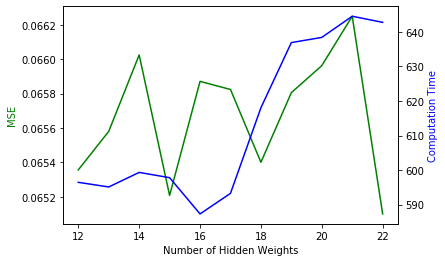

In [58]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(number_of_hidden_weights, mse, 'g-')
ax2.plot(number_of_hidden_weights, execution_time, 'b-')

ax1.set_xlabel('Number of Hidden Weights')
ax1.set_ylabel('MSE', color='g')
ax2.set_ylabel('Computation Time', color='b')

plt.show()


## Ans 1 ##
As we can see from the above graph there is no constant effect from the number of hidden nodes on either mse or computation time required to train the model. We get the best test MSE when the number of hidden layers is 22 . While computation time is minimum when the number of hidden nodes is 16 . The dataset that I have used for regression is pretty small (around 45000) rows . So the amount of change in MSE after increasing the number of hidden nodes is pretty negligible . So On 4 core CPU with 8 GB of RAM it takes around 10 minutes to get reasonable accuracy. 

## Step 8 ##
In this step we have created class named MutiLayerNeuralNetwork which contains the different neural network models. In this step we will anlyse the effect of increasing number of layer on accuracy and computation time required to train these networks

In [43]:
class MutiLayerNeuralNetwork:
    
    def __init__(self, input_size,output_size):
        self.input_size = input_size
        self.output_size = output_size
    
    def get_1_layer_model(self): 
        hidden_sizes = [12]
        model = nn.Sequential(nn.Linear(self.input_size,hidden_sizes[0]),
                               nn.Sigmoid(),
                               nn.Linear(hidden_sizes[0],self.output_size))
        return model
    
    def get_2_layer_model(self): 
        hidden_sizes = [6,12]
        model = nn.Sequential(nn.Linear(self.input_size,hidden_sizes[0]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[0],hidden_sizes[1]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[1],self.output_size))
        return model
    
    def get_3_layer_model(self): 
        hidden_sizes = [6,12,24]
        model = nn.Sequential(nn.Linear(self.input_size,hidden_sizes[0]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[0],hidden_sizes[1]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[1],hidden_sizes[2]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[2],self.output_size)
                             )
        return model
    
    def get_4_layer_model(self):
        hidden_sizes = [6,12,24,12]
        model = nn.Sequential(nn.Linear(self.input_size,hidden_sizes[0]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[0],hidden_sizes[1]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[1],hidden_sizes[2]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[2],hidden_sizes[3]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[3],self.output_size)
                             )
        return model 
    def get_5_layer_model(self):
        hidden_sizes = [6,12,24,12,6]
        model = nn.Sequential(nn.Linear(self.input_size,hidden_sizes[0]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[0],hidden_sizes[1]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[1],hidden_sizes[2]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[2],hidden_sizes[3]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[3],hidden_sizes[4]),
                              nn.Sigmoid(),
                              nn.Linear(hidden_sizes[4],self.output_size)
                              
                             )
        return model     

In [ ]:
number_of_layers = []
mse_new = []
execution_time_new = []

mnn = MutiLayerNeuralNetwork(6,1)
    
for i in range(5,6) : 
    number_of_layers.append(i)
    start_time = time.time()
    method_name = "get_"+str(i)+"_layer_model"
    model = getattr(mnn, method_name)()
    learning_rate = 0.00005
    criterion = nn.MSELoss() 
    optimizer = optim.SGD(model.parameters(),learning_rate)
    epochs = 100
    for e in range(epochs):
        running_loss = 0
        validation_loss = 0
        for (x,y) in train_dataset:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output,y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()     
        
    final_validation_loss = 0
    for  (x,y) in test_dataset:
        output = model(x)
        loss = criterion(output,y)
        final_validation_loss += loss.item()
    mse_new.append(final_validation_loss/len(test_dataset))
    execution_time_new.append(time.time() - start_time)
    print("layer "+str(i)+"completed ")

In [59]:
# values computed in google colab and cloud 
number_of_layers = [1,2,3,4]
mse = [0.0646833102698887,0.0748812712280232,0.0754261877869882,0.0755113973488441]
execution_time = [826.500959873199,1145.51496791839,1310.01435708999,1682.9545238018]

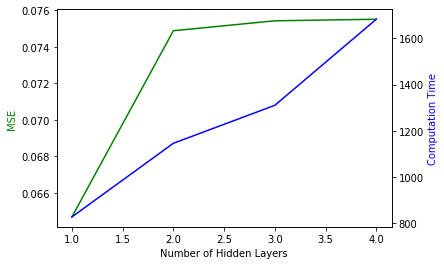

In [60]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(number_of_layers, mse, 'g-')
ax2.plot(number_of_layers, execution_time, 'b-')

ax1.set_xlabel('Number of Hidden Layers')
ax1.set_ylabel('MSE', color='g')
ax2.set_ylabel('Computation Time', color='b')

plt.show()


## Ans 2 ## 
As we can see in the above figure increasing the number of layers results in higher MSE and higher computation time . When data is too simple increasing the number of layers results in over fitting . In overfitting model tries to fit the training data but doing this will results in lower test accuracy . That's what is happening in my case . As far as computation time goes increasing number of hidden layers always increases the computation time. We got best MSE results when we had 1 hidden layer which is 0.0646 and computation time required was also minimum . So increasing the number of layers does not always result in improved performance. 

## conclusion 
Deciding the architecture of a neural network is a very important process . In particular we also have to tune hyperparameters like  number of hidden layers and number of hidden nodes in each hidden layer. We have to take extra care in each of them so that we don't overfit training data . We also have to take computation time in mind , even though we have modern hardware like gpu it might be expensive for some use cases . Balancing the computation cost with the performance we want is very important. 